In [ ]:
!jupyter nbconvert Lecture-22-Phase-Field-Basics.ipynb --to slides --post serve

# Lecture 22:  Phase Field Models

### Sections

* [Introduction](#Introduction)
* [Learning Goals](#Learning-Goals)
* [On Your Own](#On-Your-Own)
    * [The Order Parameter](#The-Order-Parameter)
* [In Class](#In-Class)
    * [The Free Energy Functional](#The-Free-Energy-Functional)
    * [The Equation of Motion](#The-Equation-of-Motion)
    * [Analytical Solution](#Analytical-Solution)
    * [Numerical Solution (FiPy)](#Numerical-Solution-(FiPy)
    * [In 2D](#In-2D)
* [Homework](#Homework)
* [Summary](#Summary)
* [Looking Ahead](#Looking-Ahead)
* [Reading Assignments and Practice](#Reading-Assignments-and-Practice)

### Introduction
----

This workbook/lecture is derived from Boettinger, et al. in Annual Review of Materials Research, v32, p163-194 (2002).  

doi: 10.1146/annurev.matsci.32.101901.155803

The phase field method makes possible the study of complex microstructural morphologies such as dendritic and eutectic solidification as well as polycrystalline growth.

The major contribution of the method is the introduction of an order parameter used to delineate phases such as solid/liquid, $\alpha~/~\beta$, etc.  The concept of an order parameter is not new.  However, smoothly varying this order parameter through an interphase interface frees us from tracking the interface position and applying boundary conditions at interfaces having complex morphologies.

[Top of Page](#Sections)

### Learning Goals
----

*  Introduction to the idea of an "order parameter".
*  Observe a practical use for the Calculus of Variations.
*  Introduction to what is meant by a non-homogeneous thermodynamic system.
*  Code a simple microstructure simulation.

[Top of Page](#Sections)

### On Your Own
----

Read this small excerpt from Boettinger's paper:

>The method employs a phase-field variable, e.g., $\phi$, which is a function of position and time, to describe whether the material is liquid or solid. The behavior
of this variable is governed by an equation that is coupled to equations for heat
and solute transport. Interfaces between liquid and solid are described by smooth
but highly localized changes of this variable between fixed values that represent
solid and liquid, (in this review, 0 and 1, respectively).

Therein is the key feature of phase field models.  The order (or the phase) is described by a field variable ($\phi$) coupled to heat and mass transfer.  The result is that complex interface shapes do not require tracking of the position of the interface.

This may not have significance to you, however there was a time when knowledge of the position of the interface was required for solidification calculations.  This boundary condition made dendrite computation difficult if not impossible.

#### The Order Parameter

![](./images/Interface.png)

The order parameter can be thought of as an envelope around probability amplitudes of atomic positions.  In the picture below we have a probability density of finding an atom at a particular position.  In this picture $\phi = 0$ might be considered the solid, and $\phi = 1$ would be the liquid.

Using the order parameter in this way makes it easier to calculate solidification microstructures - we no longer have to track the interface (you'll see how this works below).

The shape of this interface is a balance between two forces.  The energy increase for intermediate states between solid and liquid (from the bulk free energy) and energy costs associated with steep gradients in the phase-field order parameter.

[Top of Page](#Sections)

#### Review:  Calculus of Variations

The calculus of variations is a rich mathematical subject.  There are many books on the topic.  One of the canonical problems in the subject area is to compute the shortest arc between to points on a plane.  This, is a good place to begin your study of the topic.  For now I'll describe the major output of the CoV and the points relevant to phase field.

The analogy between calculus and CoV is good.  If finding the minimum of a function can be done by inspecting derivatives then the minimum of a functional can be found by inspecting the so-called 'variational derivative'.  In particular the first chapter of Lev. D. Elsgolc's book "Calculus of Variations" presents this idea nicely.

The CoV gives us the Euler-Lagrange equation.  This is the main tool of CoV:

$$ \frac{\delta F}{\delta \phi} = \frac{\partial F}{\partial \phi} - \frac{\partial}{\partial x} \frac{\partial F}{\partial \nabla \phi} = 0$$

The scalar and gradient terms in $\phi$ are treated as independent variables.  This equation is telling us that the function that minimizes the functional is the solution to the above differential equation.

[Top of Page](#Sections)

### In Class
----

#### The Free Energy Functional

The Langragian is constructed from the free energy functional (and integrated over all space, V) and that, in turn is constructed from the bulk free energy and the gradient energy thus:

$$L(\phi,\nabla\phi) = \int_V \Big[ ~~f(\phi,T) + \frac{\epsilon^2_\phi}{2}|\nabla \phi|^2~\Big]~ dV$$

Where L is the Lagrangian, the functional (hereafter F) is in the square brackets, V is the volume of the system, $\phi$ is the order parameter, T is the temperature, $\epsilon$ is the gradient energy coefficient and $\nabla$ has the usual meaning.

$f(\phi,T)$ is the free energy density.  This is often referred to as the 'bulk' free energy term and the terms in $\nabla\phi$ are the gradient energy terms.  You may also hear these terms referred to as the 'non-classical' terms.

At equilibrium the variational derivatives must satisfy the following:

$$ \frac{\delta F}{\delta \phi} = \frac{\partial f}{\partial \phi} - \epsilon^2_\phi \nabla^2 \phi = 0$$

Recall the definition of the Euler-Lagrange equation:

$$ \frac{\delta F}{\delta \phi} = \frac{\partial F}{\partial \phi} - \frac{\partial}{\partial x} \frac{\partial F}{\partial \nabla \phi} = 0$$

and the free energy functional:

$$f(\phi,T) + \frac{\epsilon^2_\phi}{2}|\nabla \phi|^2$$

The first equation above tells us that the function $\phi(x,t)$ is unchanging.  We will compute this interface profile below.  To develop a kinetic expression we make an educated guess (also known as an "ansatz" in the phase field literature) about the relaxation of a system towards equilibrium.

[Top of Page](#Sections)

#### The Equation of Motion

We assume the following functional form for the equation of motion:

$$\frac{\partial \phi}{\partial t} = - M_\phi \frac{\delta F}{\delta \phi}$$

This is the simplest expression that guarantees the free energy of the system will decrease over time.  In this form the phase-field variable, $\phi$, is non-conserved.  The conserved form takes the divergence of the expression above as is done when expression accumulation in a control volume (as in Fick's second law).

Our equation of motion is therefore:

$$\frac{\partial \phi}{\partial t} = - M_\phi \Big[\frac{\partial f}{\partial \phi} - \epsilon^2_\phi \nabla^2 \phi \Big]$$

[Top of Page](#Sections)

#### Building the Bulk Free Energy '$f$'

There are two so-called helper functions that homogenize the free energy.  The interpolating function, $p(\phi)$ and the double well function $g(\phi)$.

In [11]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

def plot_p_and_g():
    phi = np.linspace(-0.1, 1.1, 200)
    g=phi**2*(1-phi)**2
    p=phi**3*(6*phi**2-15*phi+10)

    # Changed 3 to 1 in the figure call.
    plt.figure(1, figsize=(12,6))
    plt.subplot(121)
    plt.plot(phi, g, linewidth=1.0);
    plt.xlabel('$\phi$', fontsize=18)
    plt.ylabel('$g(\phi)$', fontsize=18)

    plt.subplot(122)
    plt.plot(phi, p, linewidth=1.0);
    plt.xlabel('$\phi$', fontsize=18)
    plt.ylabel('$p(\phi)$', fontsize=18)
    
    return

<IPython.core.display.Javascript object>


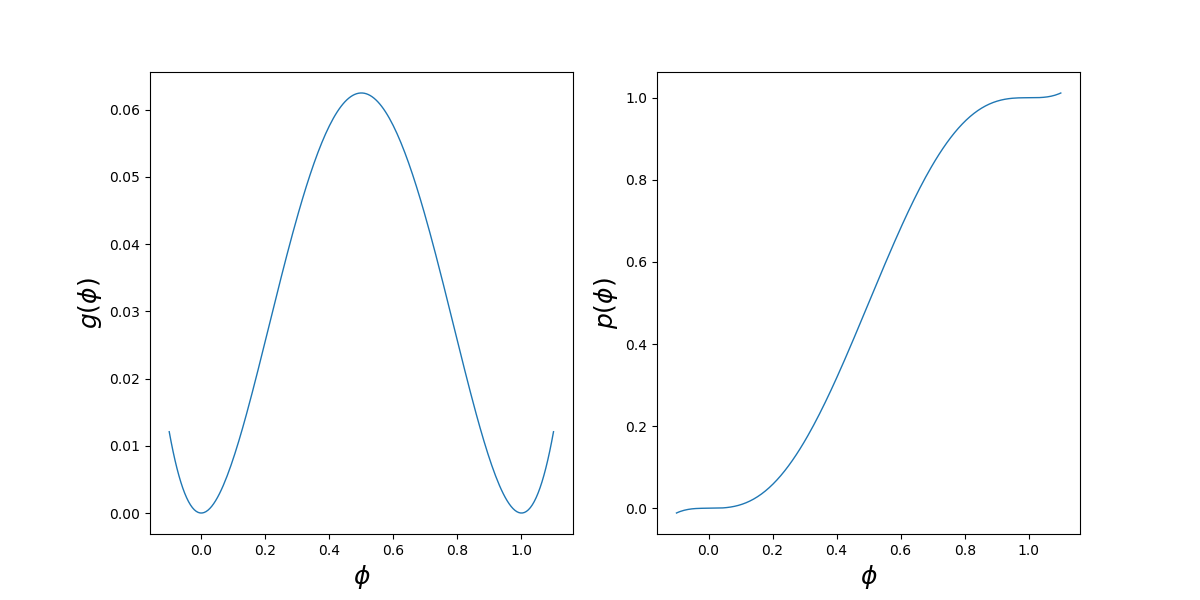

In [12]:
plot_p_and_g()

We start by using the ordinary free energy of the pure components:

 * Pure A, liquid phase - $f_A^L(T)$
 * Pure A, solid phase - $f_A^S(T)$

As we will be limiting ourselves to a pure material at this time, these are the only two free energies we need.  Near the melting point these free energies are often modeled as straight lines using the relationship for the Gibbs free energy:

$$G = H - TS$$

taking H and S to be constants.  Following conventions of the phase diagram modeling community we take the reference state of the component A to be the equilibrium phase at STP.  If this were a metal like Cu then the reference state would be the FCC phase.  For us, that will be the SOLID.  This sets:

$$f_A^S(T) = 0$$

Expanding the difference in free energy between the solid and the liquid around the melting point results in:

$$f_A^L(T)-f_A^S(T) = L_A \frac{(T_M^A - T)}{T_M^A}$$

The next step is to homogenize the free energy for component A.  We build the free energy $f(\phi,T)_A$ as follows:

$$f(\phi,T)_A = W_A~g(\phi) + f_L p(\phi) + f_S (1-p(\phi))$$

so that:

$$f(\phi,T)_A = W_A~g(\phi) + L_A \frac{(T_M^A - T)}{T_M^A}p(\phi)$$

Let us plot this and see what it looks like.

In [5]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

def plot_homogeneous_F():
    plt.fig = plt.figure(2, figsize=(10,10))
    plt.ax = plt.fig.gca(projection='3d')

    phi = np.linspace(0.0, 1.0, 100)
    temperature = np.linspace(0.0, 1.0, 100)
    phi,temperature = np.meshgrid(phi,temperature)

    W=30.0
    L=1.0
    Tm=0.5
    g=phi**2*(1-phi)**2
    p=phi**3*(6*phi**2-15*phi+10)

    f = W*g+L*p*(Tm-temperature)/Tm

    energyPlot = plt.ax.plot_surface(phi, temperature, f, label=None, 
                    cmap=plt.cm.coolwarm, rstride=5, cstride=5, alpha=0.5)
    energyPlot = plt.contour(phi, temperature, f,20)

    plt.clabel(energyPlot, inline=1, fontsize=10)
    plt.ax.set_xlabel('$\phi$')
    plt.ax.set_ylabel('T')
    plt.ax.set_zlabel('$f(\phi,t)$')
    
    return

<IPython.core.display.Javascript object>


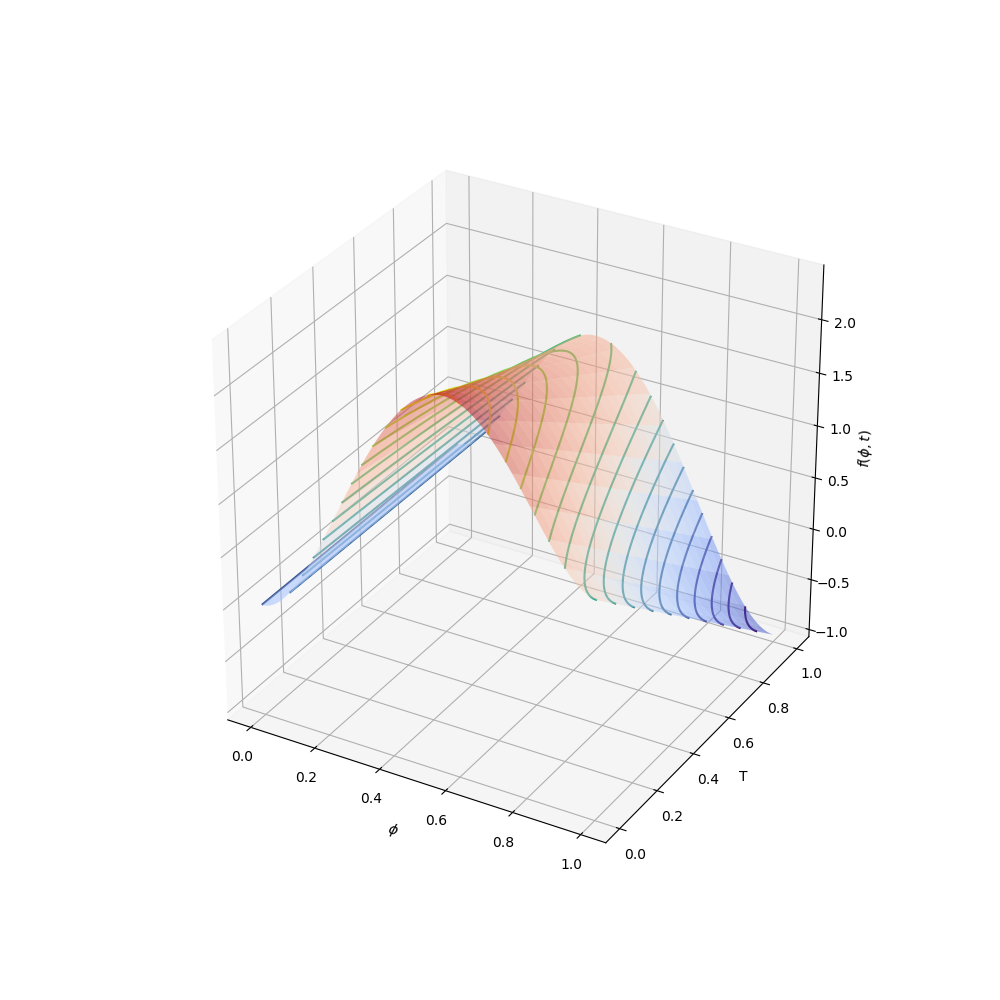

In [6]:
plot_homogeneous_F()

$$L(\phi,\nabla\phi) = \int_V \Big[ ~~f(\phi,T) + \frac{\epsilon^2_\phi}{2}|\nabla \phi|^2~\Big]~ dV$$

From here it should be clear that the free energy space is homogeneous in the order parameter and temperature.  Now that the description of the bulk energy is complete we can return to the Euler-Lagrange equations and proceed to develop our equilibrium solution and our equations of motion.

[Top of Page](#Sections)

#### Analytical Solution

The full expression for the equation of motion is:

$$\frac{\partial \phi}{\partial t} = - M_\phi \epsilon^2 
\Big[\nabla^2\phi- \frac{2W_A}{\epsilon^2} \phi(1-\phi)(1-2\phi)\Big]-\frac{30 M_\phi L_A}{T_M^A}(T_M^A - T)\phi^2(1-\phi)^2$$

While this is correct - it is often not explicitly written out like this when solving the equations numerically.  Further, it is better if you don't fully expand the derivatives when attempting the analytical solution.

There is a fair bit of algebra and a few assumptions that enable the solution to the Euler-Lagrange equation above.  I will state the procedue and leave out the gory detail.  Remember we are after the expression that gives us $\phi(x)$.  Keep this in mind as you read through the following bullet points.

 * First - assume that you are at the melting temperature.  The rationale is that this is the only temperature where BOTH phases CO-EXIST.  Any other temperature and it does not make sense to discuss an interface.  This removes the second term on the RHS of the above expression.
 * Second - you can use $\frac{d\phi}{dx}$ as an integrating factor to take the first integral of the Euler-Lagrange equation.
 * Third - after evaluating the constant (C=0 is the answer, but, why it is zero will test your reasoning skills) the equation is seperable and can be integrated.
 
 The result is:
 
 $$\phi(x) = \frac{1}{2} \Big[ 1 + \tanh \Big( \frac{x}{2\delta} \Big) \Big]$$
 
 where $\delta$ is related to the W and $\epsilon$ parameters.

In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, fixed

fig = None
def plot_equilibrium(W=500.0, epsilon=1.0):
    global fig
    if fig: plt.close(fig)
    fig = plt.figure()
    x = np.linspace(-1.0, 1.0, 200)
    phi = 0.5*(1+np.tanh(x*np.sqrt(2*W)/(2*epsilon)))
    plt.plot(x, phi, linewidth=1.0)
    plt.xlabel('$x$', fontsize=24)
    plt.ylabel('$\phi(x)$', fontsize=24)    
    return

In [10]:
print 'Hello!'

Hello!


<IPython.core.display.Javascript object>


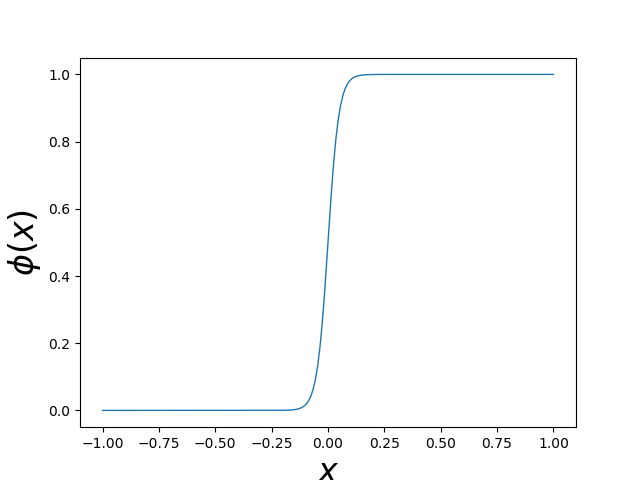

In [14]:
interact(plot_equilibrium, W=(1,1000,10), epsilon=fixed(1.0))

W and $\epsilon$ can be parameterized in terms of the surface energy and the interface thickness to make a connection with the physical world.

[Top of Page](#Sections)

#### Numerical Solution (FiPy)

In [ ]:
%matplotlib osx
from fipy import *

In [2]:
L = 1.
nx = 400
dx = L/nx
mesh = Grid1D(dx=dx, nx=nx)
phase = CellVariable(name="phase",mesh=mesh)
viewer = MatplotlibViewer(vars=(phase,),datamin=-0.1, datamax=1.1, legend=None)

This cell sets the initial conditions.  There is a helper attribute cellCenters that fetches a list of the x points.  The setValue helper functions and the 'where' keyword help you to set the initial conditions.  FiPy is linked to Matplotlib and once you created the viewer object you call .plot() to update.

In [3]:
x = mesh.cellCenters
phase.setValue(1.)
phase.setValue(0., where=x > L/2)
viewer.plot()

[Top of Page](#Sections)

#### DIY:  Code the terms to complete the phase field description.

$$\frac{\partial \phi}{\partial t} = - M_\phi \epsilon^2 
\Big[\nabla^2\phi- \frac{2W_A}{\epsilon^2} \phi(1-\phi)(1-2\phi)\Big]-\frac{30 M_\phi L_A}{T_M^A}(T_M^A - T)\phi^2(1-\phi)^2$$

In [ ]:
import sympy as sp
phi = sp.symbols('phi')
sp.init_printing()

In [ ]:
((1-phi)**2*(phi**2)).diff(phi).simplify()

In [ ]:
(phi**3*(6*phi**2-15*phi+10)).diff(phi).simplify()


$$\frac{\partial \phi}{\partial t} = - M_\phi \Big[\frac{\partial f}{\partial \phi} - \epsilon^2_\phi \nabla^2 \phi \Big]$$


$$f(\phi,T)_A = W_A~g(\phi) + L_A \frac{(T_M^A - T)}{T_M^A}p(\phi)$$

In [26]:
eps_sqrd = 0.00025 
M = 1.0
W = 0.5
Lv = 1.
Tm = 1.
T = 1.0
enthalpy = Lv*(Tm-T)/Tm
S0 = W*2.0*phase*(phase-1.0)*(2*phase-1.0) + 30*phase**2*(phase**2-2*phase+1)*enthalpy

This is our general statement of a diffusive PDE.  There is a transient term and a source term.  Translate from the description of the phase field model above.

In [27]:
eq = TransientTerm() == DiffusionTerm(coeff=eps_sqrd*M) - S0

In [28]:
for i in range(50):
    eq.solve(var = phase, dt=0.1)
    viewer.plot()

Just re-execute this cell after you change parameters.  You can execute it over and over until you are satisfied that you've reached equilibrium.

You can try changing $\kappa$, W, and T.  Changing T from the melting tmperature will result in a moving interface.  This is where things get interesting!

[Top of Page](#Sections)

#### In 2D

This one is important.  We will simulate a pair of curved particles (each with a different radius) at the melting temperature.  What do you think will happen?

In [1]:
%matplotlib osx
from fipy import *

L = 1.
nx = 200
dx = L/nx
dy = L/nx
mesh = Grid2D(dx=dx, dy=dx, nx=nx, ny=nx)
phase = CellVariable(name="phase", mesh=mesh)
x = mesh.cellCenters()[0]
y = mesh.cellCenters()[1]

In [2]:
phase.setValue(1.)
x0 = 0.0
y0 = 0.0
#phase.setValue(0., where=(
#                          ((x-x0)**2+(y-y0)**2 > L/3) & ((x-L)**2+(y-L)**2 > 0.2)
#                          )
#               )
phase.setValue(ExponentialNoiseVariable(mesh=mesh, mean=0.5))
viewer = Matplotlib2DGridViewer(vars=phase, datamin=0.0, datamax=1.0)
viewer.plot()

The strength of FiPy is that you can use the same code here in 2D as above.

In [3]:
eps_sqrd = 0.00025 
M = 1.0
W = 0.5
Lv = 1.
Tm = 1.
T = 1.
enthalpy = Lv*(Tm-T)/Tm
S0 = W*2.0*phase*(phase-1.0)*(2*phase-1.0) + 30*phase**2*(phase**2-2*phase+1)*enthalpy

In [ ]:
eq = TransientTerm() == DiffusionTerm(coeff=eps_sqrd) - S0
for i in range(500):
    eq.solve(var = phase, dt=0.05)
    viewer.plot()

[Top of Page](#Sections)